# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [3]:
#import pip
#pip.main(['install', 'psycopg2'])

In [1]:
# Импорт необходимых библиотек
import psycopg2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import datetime

import requests
from pandas import json_normalize
import time

from pandas.tseries.offsets import MonthEnd
import math

import re
import pymorphy2

In [2]:
pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
# Подключение к базе данных с параметрами, определенными выше
conn = psycopg2.connect(**pg_connection)
# Создание курсора
cursor = conn.cursor()

In [3]:
# Создание запроса к базе данных
sql_str = "select table_name from information_schema.tables where table_schema='public'"
# Выполнение запроса
cursor.execute(sql_str)
# Получение всех данных по запросу и превращение в обычный список
tables_data = [''.join(a) for a in cursor.fetchall()]
# Сохранение изменений
conn.commit()
print("Таблицы в базе human_resources:\n%s" % '\n'.join(tables_data))

Таблицы в базе human_resources:
hr_dataset
production_staff
recruiting_costs
salary_grid
tmpDB


На данном этапе мы выяснили, что всего таблиц в базе пять, и четыре из них, доступных для анализа по условиям задания, присутствуют.

Далее для составления набора предметов исследований и выдвижения каких-либо гипотез, узнаем общий объем данных и названия полей таблиц с примерами заполнений.

In [4]:
print("Имя таблицы: hr_dataset")

sql_str = "select count(*) from hr_dataset"
cursor.execute(sql_str)
tables_data = cursor.fetchone()
conn.commit()
print("Кол-во записей: %s" % tables_data)

sql_str = "select column_name from information_schema.columns where table_name = 'hr_dataset'"
cursor.execute(sql_str)
tables_data = [''.join(a) for a in cursor.fetchall()]
conn.commit()
print("Поля:\n%s" % '\n'.join(tables_data))

df_hr_dataset = pd.read_sql_query("select * from hr_dataset limit 5", conn)
df_hr_dataset.head()

Имя таблицы: hr_dataset
Кол-во записей: 310
Поля:
id
Employee Name
Employee Number
marriedid
maritalstatusid
genderid
empstatus_id
deptid
perf_scoreid
age
Pay Rate
state
zip
dob
sex
maritaldesc
citizendesc
Hispanic/Latino
racedesc
Date of Hire
Days Employed
Date of Termination
Reason For Term
Employment Status
department
position
Manager Name
Employee Source
Performance Score


,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,1,"Brown, Mia",1103024456,1,1,0,1,1,3,30,...,2008-10-27,3317,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,2,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,...,2014-01-06,1420,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,3,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,...,2014-09-29,1154,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,4,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,...,2015-02-16,58,2015-04-15,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,5,"Singh, Nan",1307059817,0,0,0,1,1,9,30,...,2015-05-01,940,None,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review


In [5]:
print("Имя таблицы: production_staff")

sql_str = "select count(*) from production_staff"
cursor.execute(sql_str)
tables_data = cursor.fetchone()
conn.commit()
print("Кол-во записей: %s" % tables_data)

sql_str = "select column_name from information_schema.columns where table_name = 'production_staff'"
cursor.execute(sql_str)
tables_data = [''.join(a) for a in cursor.fetchall()]
conn.commit()
print("Поля:\n%s" % '\n'.join(tables_data))

df_production_staff = pd.read_sql_query("select * from production_staff limit 5", conn)
df_production_staff.head()

Имя таблицы: production_staff
Кол-во записей: 256
Поля:
id
Employee Name
Race Desc
Date of Hire
TermDate
Reason for Term
Employment Status
Department
Position
Pay
Manager Name
Performance Score
Abutments/Hour Wk 1
Abutments/Hour Wk 2
Daily Error Rate
90-day Complaints


,id,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,1,"Albert, Michael",White,2011-08-01,None,N/A - still employed,Active,Production,Production Manager,$54.50,Elisa Bramante,Fully Meets,0,0,0,0
1,2,"Bozzi, Charles",Asian,2013-09-30,2014-08-07,retiring,Voluntarily Terminated,Production,Production Manager,$50.50,Elisa Bramante,Fully Meets,0,0,0,0
2,3,"Butler, Webster L",White,2016-01-28,None,N/A - still employed,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0,0,0,0
3,4,"Dunn, Amy",White,2014-09-18,None,N/A - still employed,Active,Production,Production Manager,$51.00,Elisa Bramante,Fully Meets,0,0,0,0
4,5,"Gray, Elijiah",White,2015-06-02,None,N/A - still employed,Active,Production,Production Manager,$54.00,Elisa Bramante,Fully Meets,0,0,0,0


In [6]:
print("Имя таблицы: recruiting_costs")

sql_str = "select count(*) from recruiting_costs"
cursor.execute(sql_str)
tables_data = cursor.fetchone()
conn.commit()
print("Кол-во записей: %s" % tables_data)

sql_str = "select column_name from information_schema.columns where table_name = 'recruiting_costs'"
cursor.execute(sql_str)
tables_data = [''.join(a) for a in cursor.fetchall()]
conn.commit()
print("Поля:\n%s" % '\n'.join(tables_data))

df_recruiting_costs = pd.read_sql_query("select * from recruiting_costs", conn)
df_recruiting_costs.head(22)

Имя таблицы: recruiting_costs
Кол-во записей: 22
Поля:
id
Employment Source
January 
February
March
April
May
June
July
August
September
October
November
December
Total


,id,Employment Source,January,February,March,April,May,June,July,August,September,October,November,December,Total
0,1,Billboard,520,520,520,520,0,0,612,612,729,749,910,500,6192
1,2,Careerbuilder,410,410,410,820,820,410,410,820,820,1230,820,410,7790
2,3,Company Intranet - Partner,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Diversity Job Fair,0,5129,0,0,0,0,0,4892,0,0,0,0,10021
4,5,Employee Referral,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,Glassdoor,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,Information Session,0,0,0,0,0,0,0,0,0,0,0,0,0
7,8,Internet Search,0,0,0,0,0,0,0,0,0,0,0,0,0
8,9,MBTA ads,640,640,640,640,640,640,640,1300,1300,1300,1300,1300,10980
9,10,Monster.com,500,500,500,440,500,500,440,500,440,440,500,500,5760


In [7]:
print("Имя таблицы: salary_grid")

sql_str = "select count(*) from salary_grid"
cursor.execute(sql_str)
tables_data = cursor.fetchone()
conn.commit()
print("Кол-во записей: %s" % tables_data)

sql_str = "select column_name from information_schema.columns where table_name = 'salary_grid'"
cursor.execute(sql_str)
tables_data = [''.join(a) for a in cursor.fetchall()]
conn.commit()
print("Поля:\n%s" % '\n'.join(tables_data))

df_salary_grid = pd.read_sql_query("select * from salary_grid", conn)
df_salary_grid.head(12)

Имя таблицы: salary_grid
Кол-во записей: 12
Поля:
id
Position
Salary Min
Salary Mid
Salary Max
Hourly Min
Hourly Mid
Hourly Max


,id,Position,Salary Min,Salary Mid,Salary Max,Hourly Min,Hourly Mid,Hourly Max
0,1,Administrative Assistant,30000,40000,50000,14.42,19.23,24.04
1,2,Sr. Administrative Assistant,35000,45000,55000,16.83,21.63,26.44
2,3,Accountant I,42274,51425,62299,20.32,24.72,29.95
3,4,Accountant II,50490,62158,74658,24.27,29.88,35.89
4,5,Sr. Accountant,63264,76988,92454,30.42,37.01,44.45
5,6,Network Engineer,50845,66850,88279,24.44,32.14,42.44
6,7,Sr. Network Engineer,79428,99458,120451,38.19,47.82,57.91
7,8,Database Administrator,50569,68306,93312,24.31,32.84,44.86
8,9,Sr. DBA,92863,116007,139170,44.65,55.77,66.91
9,10,Production Technician I,30000,40000,50000,14.42,19.23,24.04


### 1. Есть зависимость между perfomance score и тем, под чьим руководством работает сотрудник.

In [8]:
sql_str = 'select count(distinct "Manager Name") from hr_dataset'
cursor.execute(sql_str)
tables_data1 = cursor.fetchone()
conn.commit()
print("Кол-во менеджеров: %s" % tables_data1)

sql_str = 'select distinct "Manager Name" from hr_dataset'
cursor.execute(sql_str)
tables_data2 = cursor.fetchall()
conn.commit()
print("Менеджеры: %s" % tables_data2)


sql_str = 'select count(distinct "Performance Score") from hr_dataset'
cursor.execute(sql_str)
tables_data3 = cursor.fetchone()
conn.commit()
print("Кол-во вариантов оценок: %s" % tables_data3)

sql_str = 'select distinct "Performance Score" from hr_dataset'
cursor.execute(sql_str)
tables_data4 = cursor.fetchall()
conn.commit()
print("Оценки: %s" % tables_data4)

Кол-во менеджеров: 21
Менеджеры: [('Brian Champaigne',), ('Michael Albert',), ('Simon Roup',), ('John Smith',), ('Amy Dunn',), ('Brannon Miller',), ('Webster Butler',), ('Brandon R. LeBlanc',), ('Janet King',), ('Lynn Daneault',), ('Elijiah Gray',), ('Alex Sweetwater',), ('David Stanley',), ('Peter Monroe',), ('Eric Dougall',), ('Jennifer Zamora',), ('Board of Directors',), ('Kelley Spirea',), ('Kissy Sullivan',), ('Ketsia Liebig',), ('Debra Houlihan',)]
Кол-во вариантов оценок: 7
Оценки: [('Exceptional',), ('90-day meets',), ('N/A- too early to review',), ('Fully Meets',), ('Exceeds',), ('PIP',), ('Needs Improvement',)]


In [9]:
df_hr_dataset_mn_ps = pd.read_sql_query('select "Manager Name", "Performance Score", count("Performance Score") as ps from hr_dataset group by "Manager Name", "Performance Score" order by "Manager Name", ps desc', conn)
df_hr_dataset_mn_ps

,Manager Name,Performance Score,ps
0,Alex Sweetwater,Fully Meets,4
1,Alex Sweetwater,90-day meets,2
2,Alex Sweetwater,Exceeds,1
3,Alex Sweetwater,Needs Improvement,1
4,Alex Sweetwater,Exceptional,1
...,...,...,...
81,Webster Butler,Fully Meets,11
82,Webster Butler,N/A- too early to review,3
83,Webster Butler,90-day meets,3
84,Webster Butler,Exceeds,2


In [10]:
sql_str = 'select count(distinct "Manager Name") from production_staff'
cursor.execute(sql_str)
tables_data1 = cursor.fetchone()
conn.commit()
print("Кол-во менеджеров: %s" % tables_data1)

sql_str = 'select distinct "Manager Name" from production_staff'
cursor.execute(sql_str)
tables_data2 = cursor.fetchall()
conn.commit()
print("Менеджеры: %s" % tables_data2)


sql_str = 'select count(distinct "Performance Score") from production_staff'
cursor.execute(sql_str)
tables_data3 = cursor.fetchone()
conn.commit()
print("Кол-во вариантов оценок: %s" % tables_data3)

sql_str = 'select distinct "Performance Score" from production_staff'
cursor.execute(sql_str)
tables_data4 = cursor.fetchall()
conn.commit()
print("Оценки: %s" % tables_data4)

Кол-во менеджеров: 10
Менеджеры: [('Ketsia Liebig',), ('Amy Dunn',), (None,), ('Brannon Miller',), ('Webster Butler',), ('Michael Albert',), ('Elijiah Gray',), ('David Stanley',), ('Elisa Bramante',), ('Kelley Spirea',), ('Kissy Sullivan',)]
Кол-во вариантов оценок: 7
Оценки: [('Needs Improvement',), (None,), ('Exceptional',), ('90-day meets',), ('N/A- too early to review',), ('Fully Meets',), ('Exceeds',), ('PIP',)]


In [11]:
df_production_staff_mn_ps = pd.read_sql_query('select "Manager Name", "Performance Score", count("Performance Score") as ps from production_staff group by "Manager Name", "Performance Score" order by "Manager Name", ps desc', conn)
df_production_staff_mn_ps

,Manager Name,Performance Score,ps
0,Amy Dunn,Fully Meets,11
1,Amy Dunn,N/A- too early to review,5
2,Amy Dunn,Exceeds,2
3,Amy Dunn,Exceptional,1
4,Amy Dunn,90-day meets,1
5,Amy Dunn,PIP,1
6,Brannon Miller,Fully Meets,8
7,Brannon Miller,Exceeds,5
8,Brannon Miller,PIP,4
9,Brannon Miller,Exceptional,2


Существуют две таблицы hr_dataset и production_staff с заданными по условию полями Manager Name и Performance Score. Почти все менеджеры из таблицы production_staff присутствуют в таблице hr_dataset за исключением Elisa Bramante.

In [12]:
sql_str = """
select distinct hr_dataset."Manager Name", production_staff."Manager Name" from hr_dataset, production_staff
where array[production_staff."Manager Name"] <@ array[hr_dataset."Manager Name"]
"""
df_managers_repeat = pd.read_sql_query(sql_str, conn)
df_managers_repeat

,Manager Name,Manager Name
0,Kissy Sullivan,Kissy Sullivan
1,David Stanley,David Stanley
2,Michael Albert,Michael Albert
3,Amy Dunn,Amy Dunn
4,Kelley Spirea,Kelley Spirea
5,Brannon Miller,Brannon Miller
6,Elijiah Gray,Elijiah Gray
7,Ketsia Liebig,Ketsia Liebig
8,Webster Butler,Webster Butler


Подтверждаем, что данные таблиц по оценке работников менеджерами частично пересекаются.

In [13]:
sql_str = """
select production_staff."Manager Name", production_staff."Employee Name", production_staff."Performance Score" from production_staff
except
select hr_dataset."Manager Name", hr_dataset."Employee Name", hr_dataset."Performance Score" from hr_dataset
"""
df_production_staff_difference = pd.read_sql_query(sql_str, conn)
df_production_staff_difference

,Manager Name,Employee Name,Performance Score
0,Elijiah Gray,"King, Janet",Fully Meets
1,Elisa Bramante,"Liebig, Ketsia",Exceeds
2,Elisa Bramante,"Dunn, Amy",Fully Meets
3,Elisa Bramante,"Bozzi, Charles",Fully Meets
4,Elisa Bramante,"Immediato, Walter",Needs Improvement
5,None,None,None
6,Elisa Bramante,"Gray, Elijiah",Fully Meets
7,Michael Albert,"Sweetwater, Alex",Fully Meets
8,David Stanley,"Monkfish, Erasumus",Fully Meets
9,Elisa Bramante,"Wallace, Courtney E",Fully Meets


Для полной картины о данных зависимости показателей сотрудников от руководящих менеджеров объединим таблицы.

In [14]:
df_hr_dataset_window = pd.read_sql_query('select distinct "Manager Name", "Performance Score", count("Performance Score") over (partition by "Manager Name", "Performance Score") from hr_dataset order by "Manager Name", "Performance Score"', conn)
df_hr_dataset_window

,Manager Name,Performance Score,count
0,Alex Sweetwater,90-day meets,2
1,Alex Sweetwater,Exceeds,1
2,Alex Sweetwater,Exceptional,1
3,Alex Sweetwater,Fully Meets,4
4,Alex Sweetwater,Needs Improvement,1
...,...,...,...
81,Webster Butler,90-day meets,3
82,Webster Butler,Exceeds,2
83,Webster Butler,Fully Meets,11
84,Webster Butler,N/A- too early to review,3


In [15]:
# sql_str = """
# select distinct u."Manager Name", u."Performance Score", count(u."Performance Score") over (partition by u."Manager Name", u."Performance Score")
# from (select "Manager Name", "Employee Name", "Performance Score" from production_staff
# union
# select "Manager Name", "Employee Name", "Performance Score" from hr_dataset) as u
# order by u."Manager Name", u."Performance Score"
# """

sql_str = """
select u."Manager Name", u."Performance Score", count(u."Performance Score") as "Total"
from (select "Manager Name", "Employee Name", "Performance Score" from production_staff
union
select "Manager Name", "Employee Name", "Performance Score" from hr_dataset) as u
group by  u."Manager Name", u."Performance Score"
order by  u."Manager Name", u."Performance Score" 
"""
df_mn_ps = pd.read_sql_query(sql_str, conn)
df_mn_ps

#"Total" desc

,Manager Name,Performance Score,Total
0,Alex Sweetwater,90-day meets,2
1,Alex Sweetwater,Exceeds,1
2,Alex Sweetwater,Exceptional,1
3,Alex Sweetwater,Fully Meets,4
4,Alex Sweetwater,Needs Improvement,1
...,...,...,...
85,Webster Butler,Exceeds,2
86,Webster Butler,Fully Meets,11
87,Webster Butler,N/A- too early to review,3
88,Webster Butler,Needs Improvement,2


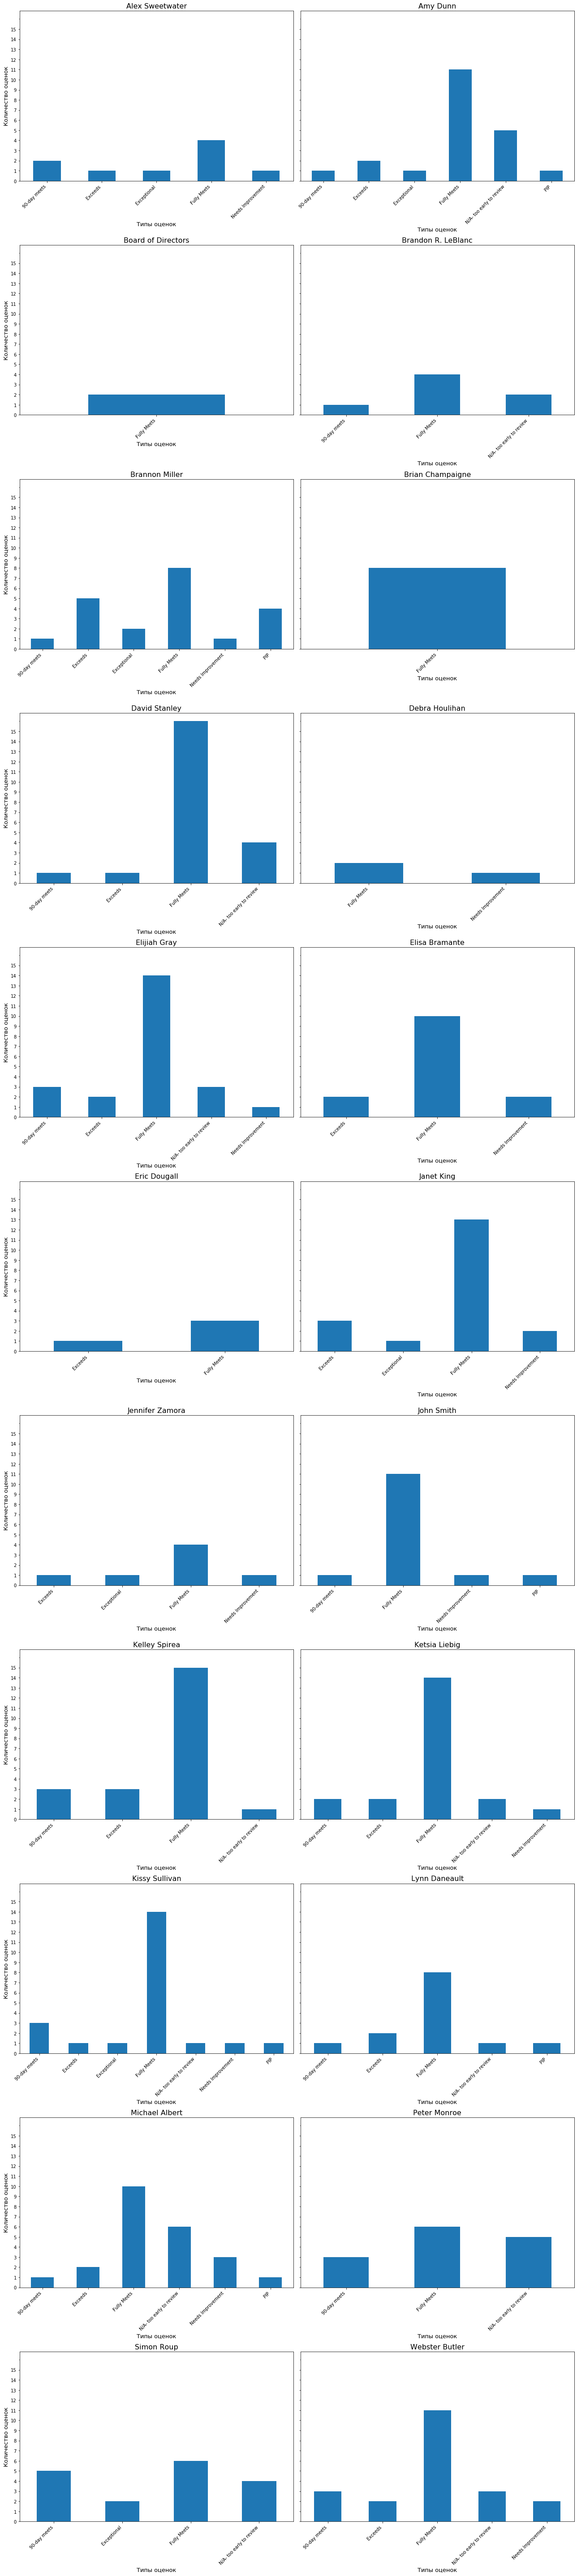

In [16]:
figure, fifteen_axes = plt.subplots(11, 2, sharey = True, figsize = (18, 80))
# Вывод циклом 22 графиков: формирование групп данных и наложение каждой на соответсвующий график методом zip
for (n, g), ax in zip(df_mn_ps.groupby('Manager Name'), fifteen_axes.flatten()):
    g.plot.bar(x = 'Performance Score', ax = ax, legend = False, fontsize = 10)
    ax.set_title(n, fontsize = 16)
    ax.set_xlabel('Типы оценок', fontsize=13)
    ax.set_ylabel('Количество оценок', fontsize=13)
    ax.set_yticks(range(0, 16, 1))
    ax.set_xticklabels(list(g['Performance Score']), rotation = 45, ha = 'right')
    plt.tight_layout()

Исходя из полученных данных, можно сделать выводы для каждого менеджера: сколько новых сотрудников, величина штата (кто работает недавно или мало / много или давно), у каких сотрудников лучше успеваемость, а кому нужна помощь.


Если перевести с английского оценки как:
* Exceptional - превосходно справляется с поставленными задачами
* Exceeds - превышает стандартные показатели (отлично)
* Fully Meets - полностью соответствует (хорошо)
* Needs Improvement - нуждается в улучшении показателей (удовлетворительно)
* PIP - требуется разработка плана по повышению успеваемости (неудовлетворительно)
* 90-day meets - на испытательном сроке
* N/A- too early to review - мало данных

,то видно, что у всех руководителей преобладают оценки полного соответсвия сотрудников занимаемым должностям.

Если не брать в расчет Совет директоров, то всего трое сотрудников у Debra Houlihan, причем один из них нуждается в улучшении показателей. Под руководством Eric Dougall работают четверо сотрудников, но один из них наоборот справляется лучше остальных, имеющих стандартные показатели.

В средней по количеству в штате сотрудников группе руководителей (Elisa Bramante, John Smith, Lynn Daneault, Peter Monroe) показатели у John Smith немного хуже остальных, но не всегда успеваемость зависит от менеджера, когда речь идет об 1-2 сотрудниках от общего числа.

Больше всего сотрудников (23) под руководством Elijiah Gray и Michael Albert, однако у сотрудников Elijiah Gray сравнительно лучшие показатели. Kissy Sullivan, Kelley Spirea и David Stanley имеют по 22 сотрудника, но их показатели, хоть незначительно, но отличаются. Например, у Kissy Sullivan есть двое сотрудников, которые не отвечают стандартам компании, при этом есть двое, которые их превосходят. В штате David Stanley и Kelley Spirea, идущих ноздря в ноздрю, отстающие сотрудники отсутвуют вовсе, одни и два сотрудника соответственно справляются на отлично. Похожая ситуация у руководителей с 21 сотрудником. У Brannon Miller пятеро сотрудников имеют плохие показатели, при это семь справляются превосходя стандарты. У остальных показатели более сглажены в пользу полного соответсвия требованиям компании.

Если не учитывать оценки 90-day meets и N/A- too early to review как не влияющие на результат, то можно сказать, что зависимость между perfomance score и тем, под чьим руководством работает сотрудник, существует, но нет принципиальной разницы в силу значительных отличий в количестве штата менеджеров. Есть руководители, у которых мало сотрудников, где разница более очевидна, но недостаточно данных для подтверждения зависимости. У руководителей с большим штатом усредненные показатели примерно одинаковые. Существует разброс в структуре показателей, например, чем меньше сотрудников соответсвуют стандарту, тем больше разделяются примерно в равных долях как несоответсвующиме стандарту, так и превосходящие его.

In [17]:
sql_str = """
select u."Manager Name", count(u."Performance Score") as "Total"
from (select "Manager Name", "Employee Name", "Performance Score" from production_staff
union
select "Manager Name", "Employee Name", "Performance Score" from hr_dataset) as u
group by  u."Manager Name"
order by "Total" desc
"""
df_number_of_employees = pd.read_sql_query(sql_str, conn)
df_number_of_employees

,Manager Name,Total
0,Michael Albert,23
1,Elijiah Gray,23
2,Kissy Sullivan,22
3,David Stanley,22
4,Kelley Spirea,22
5,Brannon Miller,21
6,Ketsia Liebig,21
7,Webster Butler,21
8,Amy Dunn,21
9,Janet King,19


In [18]:
df_mn_ps.groupby('Manager Name')['Total'].sum().sort_values(ascending = False).to_frame('Number of employees')

,Number of employees
Manager Name,
Michael Albert,23
Elijiah Gray,23
David Stanley,22
Kissy Sullivan,22
Kelley Spirea,22
Webster Butler,21
Ketsia Liebig,21
Amy Dunn,21
Brannon Miller,21


### 2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.

In [19]:
sql_str = 'select count(distinct marriedid) from hr_dataset'
cursor.execute(sql_str)
tables_data = cursor.fetchone()
conn.commit()
print("Проверка наличия двух вариантов в семейном положении: %s" % tables_data)

sql_str = 'select distinct marriedid from hr_dataset'
cursor.execute(sql_str)
tables_data = cursor.fetchall()
conn.commit()
print("Варианты семейного положения: %s" % tables_data)

sql_str = 'select count(distinct maritalstatusid) from hr_dataset'
cursor.execute(sql_str)
tables_data = cursor.fetchone()
conn.commit()
print("Количество семейных статусов: %s" % tables_data)

sql_str = 'select distinct maritalstatusid from hr_dataset'
cursor.execute(sql_str)
tables_data = cursor.fetchall()
conn.commit()
print("Варианты семейного статуса: %s" % tables_data)

Проверка наличия двух вариантов в семейном положении: 2
Варианты семейного положения: [(0,), (1,)]
Количество семейных статусов: 5
Варианты семейного статуса: [(0,), (1,), (3,), (4,), (2,)]


Так как в таблице hr_dataset в поле marriedid всего два варианта, предположим, что именно в нем содержатся ссылки по id на недоступную нам таблицу, где 0 (False) означает холост/незамужем, а 1 (True) &mdash; женат/замужем

В поле maritalstatusid вариантов значений пять. Возможно в этом поле таблицы идет детализация предыдущего поля, к примеру: медовый месяц, разведен, повторно женат и т.д. В этом случае из-за сложности интерпретации будут доступны данные без аналитики.

В таблице production_staff также содержатся данные о сроках найма сотрудников (поля Date of Hire, TermDate), но, исследуя данные сотрудников без срока увольнения, по этим полям невозможно определить период работы. Кроме того отсутсвуют ключевые поля marriedid и maritalstatusid. Так как оба поля находятся в таблице hr_dataset вместе с полем Days Employed, обозначающем продолжительность работы в компании, работать будем с этой таблицей.

Для начала проверим, есть ли сотрудники, у которых было несколько сроков работы в компании. Если сотрудники нанимались дважды или более раз, будем выводить информацию об общем сроке пребывания на службе.

In [20]:
sql_str = """
select "Employee Name", count(distinct "Date of Hire") as "Total"
from hr_dataset
group by "Employee Name"
order by "Total" desc
"""
df_number_of_periods = pd.read_sql_query(sql_str, conn)
df_number_of_periods

,Employee Name,Total
0,"Adinolfi, Wilson K",1
1,"Ait Sidi, Karthikeyan",1
2,"Akinkuolie, Sarah",1
3,"Alagbe,Trina",1
4,"Albert, Michael",1
...,...,...
305,"Woodson, Jason",1
306,"Ybarra, Catherine",1
307,"Zamora, Jennifer",1
308,"Zhou, Julia",1


In [21]:
df_number_of_periods['Total'].nunique()

1

В таблице hr_dataset 310 сотрудников. Выясняется, что все они имеют только одну дату устройства на работу. Соответственно имеют только по одному сроку работы в компании.

In [22]:
sql_str = """
select "marriedid", count("marriedid"), sum("Days Employed"), min("Days Employed"), max("Days Employed"), avg("Days Employed")
from hr_dataset
group by "marriedid"
"""
df_marriedid_dependence = pd.read_sql_query(sql_str, conn)
df_marriedid_dependence

,marriedid,count,sum,min,max,avg
0,0,187,248498,2,4339,1328.866310
1,1,123,153287,2,3611,1246.235772


In [23]:
round((df_marriedid_dependence.iloc[ 1, [1, 2, 3, 4, 5]] / df_marriedid_dependence.iloc[ 0, [1, 2, 3, 4, 5]]), 2).to_frame('ratio')

,ratio
count,0.66
sum,0.62
min,1.00
max,0.83
avg,0.94


Полученные данные показывают зависимость продолжительности работы в компании и семейного положения. Например, холостые/незамужние сотрудники работают в компании обычно дольше, чем имеющие семейный статус. Максимальные и средние значения (4339 и 1329) выше, чем у женатых/замужних (3611 и 1246), которых нанимают в полтора раза реже.

In [24]:
sql_str = """
select "maritalstatusid", count("maritalstatusid"), sum("Days Employed"), min("Days Employed"), max("Days Employed"), avg("Days Employed")
from hr_dataset
group by "maritalstatusid"
"""
df_maritalstatusid_dependence = pd.read_sql_query(sql_str, conn)
df_maritalstatusid_dependence

,maritalstatusid,count,sum,min,max,avg
0,0,137,188067,8,3674,1372.751825
1,1,123,153287,2,3611,1246.235772
2,3,12,20441,905,4339,1703.416667
3,4,8,6904,2,1602,863.000000
4,2,30,33086,8,2686,1102.866667


В результате мы видим, что показатели в поле maritalstatusid с id, равным единице, полностью соответствуют показателям такого же id из поля marriedid. Это говорит о том, что данные в полях дублируются, за исключением детализации данных по холостым/незамужним респондентам.

### 3. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

In [25]:
sql_str = """
select "age", count("age"), sum("Days Employed"), min("Days Employed"), max("Days Employed"), avg("Days Employed")
from hr_dataset
group by "age"
order by "age"
"""
df_age_dependence = pd.read_sql_query(sql_str, conn)
df_age_dependence

,age,count,sum,min,max,avg
0,25,2,3687,1476,2211,1843.500000
1,26,2,1699,794,905,849.500000
2,27,5,7735,439,2428,1547.000000
3,28,12,11551,57,2092,962.583333
4,29,15,24397,8,3611,1626.466667
5,30,15,16403,127,3317,1093.533333
6,31,25,30002,6,2336,1200.080000
7,32,12,15713,58,2645,1309.416667
8,33,17,18007,19,1954,1059.235294
9,34,19,20864,124,2386,1098.105263


Группировка по возрастам с разницей в год не дает необходимого для анализа результата из-за малого количества сотрудников, представленных в некоторых группах, и большого количества самих групп. Для более обощенных данных продолжим группировку по возрастным группам.

In [26]:
sql_str = """
select '25-34' as "Ages Group", sum("Count Ages") as "Number of Employees", min("MIN Days Employed by age") as "MIN Days Employed", max("MAX Days Employed by age") as "MAX Days Employed", round(avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min("Days Employed") as "MIN Days Employed by age", max("Days Employed") as "MAX Days Employed by age", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" < 35
group by "age") as t1
union
select '35-44' as "Ages Group", sum("Count Ages") as "Number of Employees", min("MIN Days Employed by age") as "MIN Days Employed", max("MAX Days Employed by age") as "MAX Days Employed", round(avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min("Days Employed") as "MIN Days Employed by age", max("Days Employed") as "MAX Days Employed by age", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 34 and "age" < 45
group by "age") as t2
union
select '45-54' as "Ages Group", sum("Count Ages") as "Number of Employees", min("MIN Days Employed by age") as "MIN Days Employed", max("MAX Days Employed by age") as "MAX Days Employed", round(avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min("Days Employed") as "MIN Days Employed by age", max("Days Employed") as "MAX Days Employed by age", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 44 and "age" < 55
group by "age") as t3
union
select '55+' as "Ages Group", sum("Count Ages") as "Number of Employees", min("MIN Days Employed by age") as "MIN Days Employed", max("MAX Days Employed by age") as "MAX Days Employed", round(avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min("Days Employed") as "MIN Days Employed by age", max("Days Employed") as "MAX Days Employed by age", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 54
group by "age") as t4
order by "Ages Group"
"""
df_ages_group_dependence1 = pd.read_sql_query(sql_str, conn)
df_ages_group_dependence1

,Ages Group,Number of Employees,MIN Days Employed,MAX Days Employed,AVG Days Employed
0,25-34,124.0,6,3611,1259.0
1,35-44,110.0,2,3674,1387.0
2,45-54,61.0,2,4339,1322.0
3,55+,15.0,98,1973,1136.0


In [27]:
sql_str = """
select '25-29' as "Ages Group", sum("Count Ages") as "Number of Employees", min("MIN Days Employed by age") as "MIN Days Employed", make_interval(days => max("MAX Days Employed by age")) as "MAX Days Employed", round(avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min("Days Employed") as "MIN Days Employed by age", max("Days Employed") as "MAX Days Employed by age", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" < 30
group by "age") as t1
union
select '30-39' as "Ages Group", sum("Count Ages") as "Number of Employees", min("MIN Days Employed by age") as "MIN Days Employed", make_interval(days => max("MAX Days Employed by age")) as "MAX Days Employed", round(avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min("Days Employed") as "MIN Days Employed by age", max("Days Employed") as "MAX Days Employed by age", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 29 and "age" < 40
group by "age") as t2
union
select '40-49' as "Ages Group", sum("Count Ages") as "Number of Employees", min("MIN Days Employed by age") as "MIN Days Employed", make_interval(days => max("MAX Days Employed by age")) as "MAX Days Employed", round(avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min("Days Employed") as "MIN Days Employed by age", max("Days Employed") as "MAX Days Employed by age", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 39 and "age" < 50
group by "age") as t3
union
select '50-59' as "Ages Group", sum("Count Ages") as "Number of Employees", min("MIN Days Employed by age") as "MIN Days Employed", make_interval(days => max("MAX Days Employed by age")) as "MAX Days Employed", round(avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min("Days Employed") as "MIN Days Employed by age", max("Days Employed") as "MAX Days Employed by age", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 49 and "age" < 60
group by "age") as t4
union
select '60+' as "Ages Group", sum("Count Ages") as "Number of Employees", min("MIN Days Employed by age") as "MIN Days Employed", make_interval(days => max("MAX Days Employed by age")) as "MAX Days Employed", round(avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min("Days Employed") as "MIN Days Employed by age", max("Days Employed") as "MAX Days Employed by age", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 59
group by "age") as t4
order by "Ages Group"
"""
df_ages_group_dependence2 = pd.read_sql_query(sql_str, conn)
df_ages_group_dependence2

,Ages Group,Number of Employees,MIN Days Employed,MAX Days Employed,AVG Days Employed
0,25-29,36.0,8,3611 days,1366.0
1,30-39,152.0,6,3674 days,1270.0
2,40-49,84.0,2,3244 days,1303.0
3,50-59,28.0,62,4339 days,1413.0
4,60+,10.0,98,1973 days,925.0


In [28]:
sql_str = """
select '25-34' as "Ages Group", sum("Count Ages") as "Number of Employees", div(avg("AVG Days Employed by age"), 365) || ' years ' || round(mod(avg("AVG Days Employed by age"), 365) / 30) || ' mons' as "AVG Term Employed"
from
(select "age", count("age") as "Count Ages", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" < 35
group by "age") as t1
union
select '35-44' as "Ages Group", sum("Count Ages") as "Number of Employees", div(avg("AVG Days Employed by age"), 365) || ' years ' || round(mod(avg("AVG Days Employed by age"), 365) / 30) || ' mons' as "AVG Term Employed"
from
(select "age", count("age") as "Count Ages", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 34 and "age" < 45
group by "age") as t2
union
select '45-54' as "Ages Group", sum("Count Ages") as "Number of Employees", div(avg("AVG Days Employed by age"), 365) || ' years ' || round(mod(avg("AVG Days Employed by age"), 365) / 30) || ' mons' as "AVG Term Employed"
from
(select "age", count("age") as "Count Ages", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 44 and "age" < 55
group by "age") as t3
union
select '55+' as "Ages Group", sum("Count Ages") as "Number of Employees", div(avg("AVG Days Employed by age"), 365) || ' years ' || round(mod(avg("AVG Days Employed by age"), 365) / 30) || ' mons' as "AVG Term Employed"
from
(select "age", count("age") as "Count Ages", avg("Days Employed") as "AVG Days Employed by age"
from hr_dataset
where "age" > 54
group by "age") as t4
order by "Ages Group"
"""
df_ages_group_dependence_avg = pd.read_sql_query(sql_str, conn)
df_ages_group_dependence_avg

,Ages Group,Number of Employees,AVG Term Employed
0,25-34,124.0,3 years 5 mons
1,35-44,110.0,3 years 10 mons
2,45-54,61.0,3 years 8 mons
3,55+,15.0,3 years 1 mons


Измерить срок по возрастным группам можно с использованием в расчетах двух полей (Date of Hire, Days Employed) путем нахождения периода сразу в нужном формате с помощью функции age.

In [29]:
sql_str = """
select '25-34' as "Ages Group", '' || sum("Count Ages") as "Number of Employees", '' || min("MIN Days Employed by age") as "MIN Days Employed", '' || max("MAX Days Employed by age") as "MAX Days Employed", '' || date_trunc('day', avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "MIN Days Employed by age", max(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "MAX Days Employed by age", avg(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "AVG Days Employed by age"
from hr_dataset
where "age" < 35
group by "age") as t1
union
select '35-44' as "Ages Group", '' || sum("Count Ages") as "Number of Employees", '' || min("MIN Days Employed by age") as "MIN Days Employed", '' || max("MAX Days Employed by age") as "MAX Days Employed", '' || date_trunc('day', avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "MIN Days Employed by age", max(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "MAX Days Employed by age", avg(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "AVG Days Employed by age"
from hr_dataset
where "age" > 34 and "age" < 45
group by "age") as t2
union
select '45-54' as "Ages Group", '' || sum("Count Ages") as "Number of Employees", '' || min("MIN Days Employed by age") as "MIN Days Employed", '' || max("MAX Days Employed by age") as "MAX Days Employed", '' || date_trunc('day', avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "MIN Days Employed by age", max(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "MAX Days Employed by age", avg(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "AVG Days Employed by age"
from hr_dataset
where "age" > 44 and "age" < 55
group by "age") as t3
union
select '55+' as "Ages Group", '' || sum("Count Ages") as "Number of Employees", '' || min("MIN Days Employed by age") as "MIN Days Employed", '' || max("MAX Days Employed by age") as "MAX Days Employed", '' || date_trunc('day', avg("AVG Days Employed by age")) as "AVG Days Employed"
from
(select "age", count("age") as "Count Ages", min(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "MIN Days Employed by age", max(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "MAX Days Employed by age", avg(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire")) as "AVG Days Employed by age"
from hr_dataset
where "age" > 54
group by "age") as t4
order by "Ages Group"
"""
df_ages_group_dependence_age = pd.read_sql_query(sql_str, conn)
df_ages_group_dependence_age

,Ages Group,Number of Employees,MIN Days Employed,MAX Days Employed,AVG Days Employed
0,25-34,124,6 days,9 years 10 mons 19 days,3 years 4 mons 40 days
1,35-44,110,2 days,10 years 21 days,3 years 8 mons 46 days
2,45-54,61,2 days,11 years 10 mons 17 days,3 years 6 mons 42 days
3,55+,15,3 mons 6 days,5 years 4 mons 24 days,3 years 39 days


В поле AVG Days Employed видно, что количество дней больше обычного. Это связано с типом интервал данного поля. Данные о месяцах и днях хранятся отдельно из-за разного количества дней, встречающихся в месяцах. Поэтому результат двойной агрегации выдал специфичный результат.

In [30]:
sql_str = """
select max("Date of Hire" + "Days Employed"  * interval '1 day') as "Issue Date"
from hr_dataset
"""
df_issue_date = pd.read_sql_query(sql_str, conn)
df_issue_date

,Issue Date
0,2017-11-26


In [31]:
sql_str = """
select max("Date of Hire" + "Days Employed"  * interval '1 day')
from hr_dataset
"""
cursor.execute(sql_str)
tables_data = cursor.fetchone()
conn.commit()
print("Последняя дата обновления данных в таблице hr_dataset: %s" % tables_data)

Последняя дата обновления данных в таблице hr_dataset: 2017-11-26 00:00:00


Данные действительны на дату 26 ноября 2017 года.


В целом зависимость продолжительности работы в компании от возраста существует, но не значительная. Средние показатели групп укладываются в срок от 3 до 4 лет. Разница в группах составила около 9 месяцев. Но группа 50+ с минимальным средним значением состоит из 15 человек, что в 7 с лишним раз меньше, чем количество сотрудников в группе 35-44 с наибольшим средним значением. Для более достоверных выводов требуется больше данных &mdash; большее количество участников выборки, особенно в группах 45-54 и 55+.

### 4. Есть зависимость между количеством привлеченных сотрудников и продолжительностью их работы в компании от источника и бюджета на привлечение.

Есть две таблицы hr_dataset и recruiting_costs. В первой есть данные о сотрудниках, во второй данные о стоимости привлечения за отчетный период (год). Год не указан, но если маркетинговая политика в отношении привлечения сотрудников не изменялась в течение нескольких лет, мы можем проанализировать, зависит ли срок службы сотрудников от привлечения через платный или бесплатный источник, и если источник платный, какое влияние оказывает стоимость привлечения.

Перед слиянием двух таблиц hr_dataset и recruiting_costs по полям Employee Source и Employment Source проверим отличие в содержании каждого из них.

In [32]:
sql_str = """
(select distinct "Employee Source"
from hr_dataset
except
select "Employment Source"
from recruiting_costs)
union
(select "Employment Source"
from recruiting_costs
except
select distinct "Employee Source"
from hr_dataset)
"""
df_employment_source_dif = pd.read_sql_query(sql_str, conn)
df_employment_source_dif

,Employee Source
0,Indeed


Отличием является лишь один источник привлечения Indeed, который встречается в таблице hr_dataset и отсутствует в recruiting_costs. Чтобы учесть все источники, объединим таблицы с помощью left outer join.

In [33]:
sql_str = """
select distinct hr_dataset."Employee Source" as "Employee Source", count(hr_dataset."Employee Name") as "Number of Employees", '' || round(avg("Days Employed"), 0) as "AVG Days Employed", '' || date_trunc('day', avg(age(("Date of Hire" + "Days Employed"  * interval '1 day'), "Date of Hire"))) as "AVG Terms Employed", '' || recruiting_costs."Total" as "Total Costs"
from hr_dataset left outer join recruiting_costs on (hr_dataset."Employee Source" = recruiting_costs."Employment Source")
group by "Employee Source", "Total Costs"
order by hr_dataset."Employee Source"
"""
df_employee_count_costs = pd.read_sql_query(sql_str, conn)
df_employee_count_costs

,Employee Source,Number of Employees,AVG Days Employed,AVG Terms Employed,Total Costs
0,Billboard,16,1681,4 years 6 mons 36 days,6192
1,Careerbuilder,1,2428,6 years 7 mons 22 days,7790
2,Company Intranet - Partner,1,444,1 year 2 mons 17 days,0
3,Diversity Job Fair,29,1340,3 years 7 mons 31 days,10021
4,Employee Referral,31,1252,3 years 4 mons 33 days,0
5,Glassdoor,14,1135,3 years 38 days,0
6,Indeed,8,308,9 mons 33 days,None
7,Information Session,4,1552,4 years 2 mons 28 days,0
8,Internet Search,6,1274,3 years 5 mons 25 days,0
9,MBTA ads,17,1580,4 years 3 mons 26 days,10980


>*Разница в днях в полях AVG Days Employed и AVG Terms Employed достигает недели из-за разницы в подходе к расчетам. Этот факт и, как отмечалось ранее, количество дней в месяце, превышающее стандартное, связано со спецификой хранения данных типа interval.*

В представленных результатах выборки уже видно, что не все платные источники хорошо работают на привлечение, тем не менее в целом количество привлеченных сотрудников выше, если источник платный.

Например, с помощью Careerbuilder привлечен один сотрудник, а бюджет на привлечение только за отчетный период составил 7790 долларов. Тем не менее сотрудник проработал почти семь лет, что в ва раза выше средних показателей. Возможно это того стоило.

Источник Indeed, который в отчетном периоде отсутствует в списках подрядной организации, привлек 8 человек, однако средний срок службы их составил всего 10 месяцев. Возможно это и стало причиной отказа от услуг компании в отчетном году.

Pay Per Click и Pay Per Click - Google, источники привлечения с интернет-ресурсов по оплате за клик (скорее всего контекстная реклама) показали противоположные результаты. Если в первом случае привлечено всего 2 человека, которые проработали всего два дня. Во втором случае привлечен 21 человек (что в 10 раз больше) и со средним сроком службы 3,5 года. При этом сумма затрат в год на этот источник только менее трех раз превышает затраты на первый. Но есть Professional Society, которая привлекла 20 человек за годовой бюджет 1200 долларов, даже меньший, чем через Pay Per Click.

Стоит отметить полезность реферальной программы Vendor Referral (привлечение сотрудников по рекомендациям) и Word of Mouth (за счет репутации компании), с помощью которых удалось бесплатно привлечь 28 сотрудников, которые в среднем проработали почти три года. Социальные сети (Social Networks - Facebook Twitter etc) с годовым бюджетом 5,5 тыс. долларов привлекли за все время 11 человек, которые в среднем проработали около трех лет, что чуть меньше средних показателей.

Больше всего сотрудников (29) привлекла Diversity Job Fair, которой в год заплатили 10 тыс. долларов. Почти 11 тыс. долларов заплатили MBTA ads, которая привлекла 17 сотрудников. Но средний срок их службы на полтора года превышает средние показатели. В то же время Monster.com привлекла 24 сотрудника с превышающим средние показатели периодом работы и годовым бюджетом в два раза меньше.


## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [34]:
#import requests

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [36]:
vk_token = 'e6ba04fd4c0457e395029cf75aef013dfde74a3013798a1d6e26f57d22049f430d8ceca4471002bccb75e'
url = 'https://api.vk.com/method/account.getProfileInfo?access_token=' + str(vk_token) + '&v=5.92'
response = getjson(url)
print(response)

{'response': {'first_name': 'Il', 'id': 619316383, 'last_name': 'Perviy', 'home_town': '', 'status': '', 'bdate': '12.8.1981', 'bdate_visibility': 1, 'phone': '+7 *** *** ** 70', 'relation': 0, 'sex': 2}}


In [37]:
# получаем последнюю запись из паблика Skillbox Вконтакте
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&count=1&v=5.92'
response = getjson(url)
print(response)

{'response': {'count': 3178, 'items': [{'id': 117226, 'from_id': -66669811, 'owner_id': -66669811, 'date': 1603292181, 'marked_as_ads': 0, 'post_type': 'post', 'text': 'Вы никогда не перепутаете «Магнит» с «Пятёрочкой», а при упоминании «Сбербанка» вспомнится зелёный кружок. Всё это — заслуга бренд-дизайнеров.\n\nРассказываем об этой профессии: с примерами и картинками. \n\n#Статья_Skillbox #Skillbox_Дизайн', 'attachments': [{'type': 'link', 'link': {'url': 'https://skillbox.ru/media/design/brend_dizayner_chem_zanimaetsya_i_chto_dolzhen_umet/?utm_source=skillbox.media&utm_medium=vk&utm_campaign=profession-brand-designer&utm_content=articles&utm_term=whoisbranddesigner', 'title': 'Бренд-дизайнер: чем занимается и что должен уметь', 'caption': 'skillbox.ru', 'description': 'Вы никогда не перепутаете «Магнит» с «Пятёрочкой», а при упоминании «Сбербанка» вспомнится зелёный кружок. Всё это — заслуга бренд-дизайнеров.', 'photo': {'album_id': -26, 'date': 1603292187, 'id': 457317296, 'owner_i

In [38]:
# сдвигаем запрос и получаем предпоследнюю запись из паблика Skillbox Вконтакте
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=1&count=1&v=5.92'
response = getjson(url)
print(response)

{'response': {'count': 3178, 'items': [{'id': 117219, 'from_id': -66669811, 'owner_id': -66669811, 'date': 1603281996, 'marked_as_ads': 0, 'post_type': 'post', 'text': 'Окей, гугл, какая песня играет в моей голове?\nКонечно, сервис пока не умеет читать мысли. Но достаточно напеть или насвистеть мелодию, и он найдет ее среди миллионов треков со всего мира.\n\nТакая функция появилась в последней версии приложения Google для Android и пока только в некоторых странах. Достаточно найти виджет Google Search и нажать кнопку «Search a song» («Искать песню»). Затем надо петь, мычать, свистеть или гудеть, стараясь повторить мелодию из головы.\n\nСовсем необязательно быть гением вокала — сервис учитывает различные степени музыкальной восприимчивости. Проще говоря, даже если вы не попали ни в одну ноту, Google все равно поймет вас и покажет возможные варианты.\n\nОжидается, что в ближайшее время дополнение будет доступно и для российских пользователей.\n\n#новости_Skillbox #Skillbox_программирован

In [40]:
date = 1603187026
dt = (datetime.datetime.fromtimestamp(date)).strftime('%Y-%m-%d %H:%M:%S')
print(dt)

2020-10-20 12:43:46


In [41]:
date = 1603206018
dt = (datetime.datetime.fromtimestamp(date)).strftime('%Y-%m-%d %H:%M:%S')
print(dt)

2020-10-20 18:00:18


In [42]:
response['response']['count']

3178

Всего 3178 постов. Чтобы увидеть общую картину активности пользователей и потом выбрать отдельный период для анализа, выгрузим посты за все время.

In [43]:
blocks = []

count = 60
offset = 0
while offset < count * count:
    # Секундный интервал между итерациями
    time.sleep(1)
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=' + str(offset) + '&count=' + str(count) + '&v=5.92'
    response = getjson(url)
    block = response['response']['items']
    blocks.extend(block)
    offset += count

In [44]:
df_norm = json_normalize(blocks)
df_norm

,id,from_id,owner_id,date,marked_as_ads,post_type,text,attachments,is_favorite,post_source.type,...,likes.can_like,likes.can_publish,reposts.count,reposts.user_reposted,views.count,post_source.platform,copy_history,signer_id,post_source.url,post_source.data
0,117226,-66669811,-66669811,1603292181,0,post,Вы никогда не перепутаете «Магнит» с «Пятёрочк...,"[{'type': 'link', 'link': {'url': 'https://ski...",False,api,...,1,1,0,0,9121.0,NaN,NaN,NaN,NaN,NaN
1,117219,-66669811,-66669811,1603281996,0,post,"Окей, гугл, какая песня играет в моей голове?\...","[{'type': 'photo', 'photo': {'album_id': -7, '...",False,api,...,1,1,4,0,12743.0,NaN,NaN,NaN,NaN,NaN
2,116802,-66669811,-66669811,1603206018,0,post,"Давайте на спор: скорее всего, вы не знаете, ч...","[{'type': 'link', 'link': {'url': 'https://ski...",False,api,...,1,1,5,0,13131.0,NaN,NaN,NaN,NaN,NaN
3,116666,-66669811,-66669811,1603187026,0,post,Инстаграм и Фейсбук — эффективные площадки для...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,api,...,1,1,16,0,18039.0,NaN,NaN,NaN,NaN,NaN
4,116462,-66669811,-66669811,1603123227,0,post,"Разбираемся, с чего начинать в программировани...","[{'type': 'link', 'link': {'url': 'https://ski...",False,api,...,1,1,5,0,16166.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173,19003,-66669811,-66669811,1459681810,0,post,#internetmarketing #business #skillbox\n\n15 с...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,vk,...,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3174,18999,-66669811,-66669811,1459613053,0,post,#internetmarketing #business #skillbox\n\nБлес...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,vk,...,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3175,18998,-66669811,-66669811,1459595119,0,post,#movie #internetmarketing #business #skillbox ...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,vk,...,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3176,18994,-66669811,-66669811,1459515013,0,post,#studio #business #skillbox \n\n4 вида рекламн...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,vk,...,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
changed = []
for post in blocks:
         
    try:
        id = post['id']
    except:
        id = 0
             
    try:
        date = datetime.datetime.fromtimestamp(int(post['date']))
    except:
        date = ''
        
    try:
        month_number = datetime.datetime.fromtimestamp(int(post['date'])).strftime('%m')
    except:
        month_number = ''
        
    try:
        month = datetime.datetime.fromtimestamp(int(post['date'])).strftime('%B')
    except:
        month = ''
 
    try:
        weekday = datetime.datetime.fromtimestamp(int(post['date'])).strftime('%A')
    except:
        weekday = ''
 
    try:
        time = datetime.datetime.fromtimestamp(int(post['date'])).strftime('%H')
    except:
        time = ''
             
             
    try:
        likes = post['likes']['count']
    except:
        likes = 0
             
    try:
        reposts = post['reposts']['count']
    except:
        reposts = 0
             
    try:
        comments = post['comments']['count']
    except:
        comments = 0
             
    try:
        views = post['views']['count']
    except:
        views = 0
             
    try:
        text = post['text']
    except:
        text = ''
             
    changed_post = {
        'id' : id,
        'date' : date,
        'month_number' : month_number,
        'month' : month,
        'weekday' : weekday,
        'time' : time,
        'likes' : likes,
        'reposts' : reposts,
        'comments' : comments,
        'views' : views, 
        'text' : str(text)
        }
         
    changed.append(changed_post)

In [46]:
df_changed_norm = json_normalize(changed)
df_changed_norm

,id,date,month_number,month,weekday,time,likes,reposts,comments,views,text
0,117226,2020-10-21 17:56:21,10,October,Wednesday,17,25,0,6,9121,Вы никогда не перепутаете «Магнит» с «Пятёрочк...
1,117219,2020-10-21 15:06:36,10,October,Wednesday,15,62,4,2,12743,"Окей, гугл, какая песня играет в моей голове?\..."
2,116802,2020-10-20 18:00:18,10,October,Tuesday,18,43,5,5,13131,"Давайте на спор: скорее всего, вы не знаете, ч..."
3,116666,2020-10-20 12:43:46,10,October,Tuesday,12,113,16,2,18039,Инстаграм и Фейсбук — эффективные площадки для...
4,116462,2020-10-19 19:00:27,10,October,Monday,19,50,5,2,16166,"Разбираемся, с чего начинать в программировани..."
...,...,...,...,...,...,...,...,...,...,...,...
3173,19003,2016-04-03 14:10:10,04,April,Sunday,14,4,0,0,0,#internetmarketing #business #skillbox\n\n15 с...
3174,18999,2016-04-02 19:04:13,04,April,Saturday,19,1,0,0,0,#internetmarketing #business #skillbox\n\nБлес...
3175,18998,2016-04-02 14:05:19,04,April,Saturday,14,3,0,0,0,#movie #internetmarketing #business #skillbox ...
3176,18994,2016-04-01 15:50:13,04,April,Friday,15,6,0,0,0,#studio #business #skillbox \n\n4 вида рекламн...


In [47]:
date = df_changed_norm['date'][0]
dates = []
while date > df_changed_norm['date'][3177]:
    
    date = date - MonthEnd(1)
    dates.append(date)

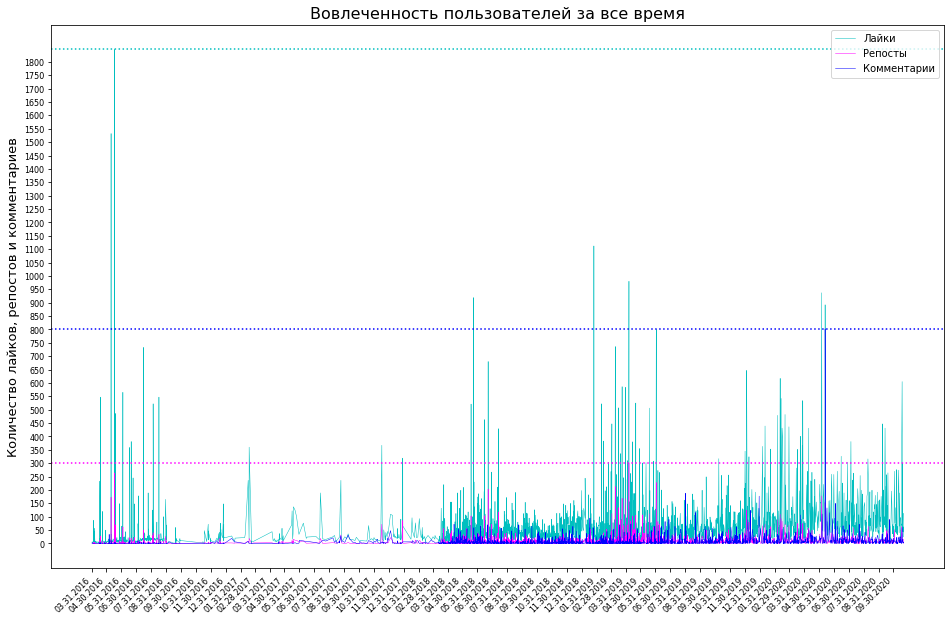

In [48]:
plt.figure(figsize=(16,10))
likes = plt.plot(df_changed_norm['date'], df_changed_norm['likes'], label='Лайки', color = 'c')
reposts = plt.plot(df_changed_norm['date'], df_changed_norm['reposts'], label='Репосты', color = 'magenta')
comments = plt.plot(df_changed_norm['date'], df_changed_norm['comments'], label='Комментарии', color = 'b')
plt.axhline(y = df_changed_norm['likes'].max(), ls=':', color = 'c')
plt.axhline(y = df_changed_norm['reposts'].max(), ls=':', color='magenta')
plt.axhline(y = df_changed_norm['comments'].max(), ls=':', color='b')
plt.setp([likes, reposts, comments], linewidth = 0.5, alpha = 1)
plt.xlabel(None)
plt.ylabel('Количество лайков, репостов и комментариев', fontsize = 13)
plt.xticks(dates, labels = [pd.to_datetime(str(date)).strftime("%m.%d.%Y") for date in dates], rotation = 45, ha = 'right', fontsize = 8)
plt.yticks(range(0, math.ceil(np.max(df_changed_norm['likes'])), 50), fontsize = 8)
plt.legend(loc = 'upper right')
plt.title('Вовлеченность пользователей за все время', fontsize = 16)
plt.show()

На графике показана активность пользователей, выраженная количеством лайков, постов и комментариев. Численностью заметно преобладают лайки (медиана 35, макс. значение 1847 в мае 2016 года), далее идут репосты (медиана 3, макс. значение 301 в апреле 2019 года) и комментарии (медиана 1, макс. значение 802 в мае 2020 года).

За все время можно выделить три периода активности:
* С самого начала до августа 2016 года период неравномерной средней активности.
* С сентября 2016 года до середины марта 2018 года период слабой активности. Также попадает на тестовый период и начало полноценной работы платформы Skillbox. Из прошлой курсовой известно, что основная деятельность компании началась с января 2018 года.
* С середины марта 2018 по настоящее время период наибольшей активности. Рассмотрим его ближе.

In [49]:
df_active = df_changed_norm[df_changed_norm['date'] > '2018-3-1']
df_active

,id,date,month_number,month,weekday,time,likes,reposts,comments,views,text
0,117226,2020-10-21 17:56:21,10,October,Wednesday,17,25,0,6,9121,Вы никогда не перепутаете «Магнит» с «Пятёрочк...
1,117219,2020-10-21 15:06:36,10,October,Wednesday,15,62,4,2,12743,"Окей, гугл, какая песня играет в моей голове?\..."
2,116802,2020-10-20 18:00:18,10,October,Tuesday,18,43,5,5,13131,"Давайте на спор: скорее всего, вы не знаете, ч..."
3,116666,2020-10-20 12:43:46,10,October,Tuesday,12,113,16,2,18039,Инстаграм и Фейсбук — эффективные площадки для...
4,116462,2020-10-19 19:00:27,10,October,Monday,19,50,5,2,16166,"Разбираемся, с чего начинать в программировани..."
...,...,...,...,...,...,...,...,...,...,...,...
2516,22596,2018-03-12 13:22:31,03,March,Monday,13,14,1,6,3733,Привет!\nЛовите календарь новой недели. Выбира...
2517,22586,2018-03-07 13:00:52,03,March,Wednesday,13,22,0,1,4827,"Мы не можем обойтись без музыки, и поэтому пер..."
2518,22581,2018-03-05 17:23:45,03,March,Monday,17,30,0,3,7023,3 марта 2018 года в офисе Skillbox прошло меро...
2519,22572,2018-03-05 11:11:59,03,March,Monday,11,16,1,4,5760,Доброе утро!\nПредставляем вам новый календарь...


In [50]:
date = df_changed_norm['date'][0]
dates = []
while date > df_changed_norm['date'][2520]:
    date = date - MonthEnd(1)
    dates.append(date)

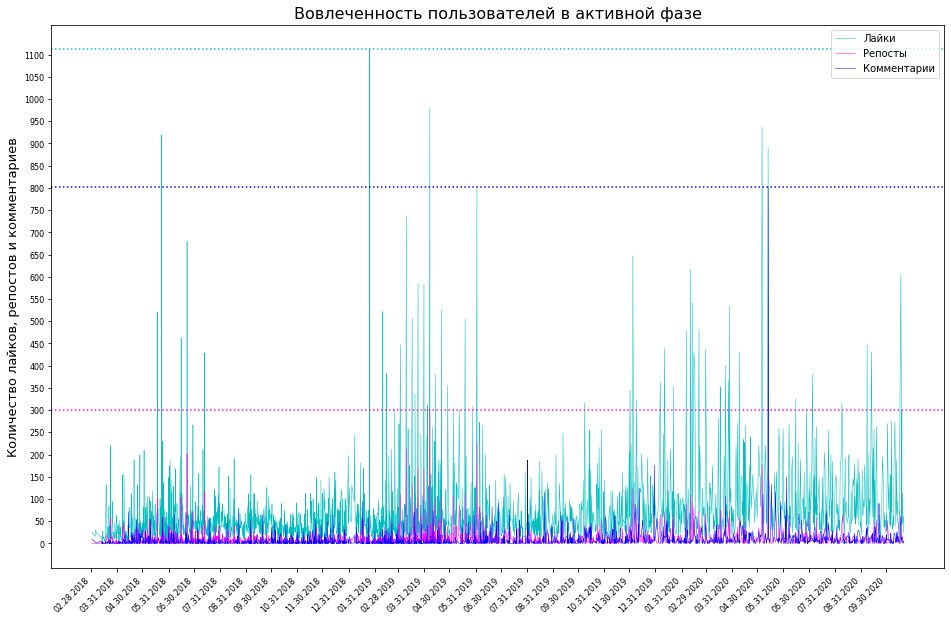

In [51]:
plt.figure(figsize=(16,10))
likes = plt.plot(df_active['date'], df_active['likes'], label='Лайки', color = 'c')
reposts = plt.plot(df_active['date'], df_active['reposts'], label='Репосты', color = 'magenta')
comments = plt.plot(df_active['date'], df_active['comments'], label='Комментарии', color = 'b')
plt.axhline(y = df_active['likes'].max(), ls=':', color = 'c')
plt.axhline(y = df_active['reposts'].max(), ls=':', color='magenta')
plt.axhline(y = df_active['comments'].max(), ls=':', color='b')
plt.setp([likes, reposts, comments], linewidth = 0.5, alpha = 1)
plt.xlabel(None)
plt.ylabel('Количество лайков, репостов и комментариев', fontsize = 13)
plt.xticks(dates, labels = [pd.to_datetime(str(date)).strftime("%m.%d.%Y") for date in dates], rotation = 45, ha = 'right', fontsize = 8)
plt.yticks(range(0, math.ceil(np.max(df_active['likes'])), 50), fontsize = 8)
plt.legend(loc = 'upper right')
plt.title('Вовлеченность пользователей в активной фазе', fontsize = 16)
plt.show()

В этот период видна сезонная зависимость. Наибольшая активность пользователей приходится на весенние месяцы (и в начале лета 2018), наименьшая на осень. Однако к 2020 году влияние сезонов становится менее заметным из-за оптимизации SMM-маркетинга компании и, возможно, влияния макрофакторов. Поэтому для исследований предлагается выбрать годовой период с ноября прошлого года, как наиболее репрезентативный в новых реалиях.

In [52]:
df_active_year = df_changed_norm[df_changed_norm['date'] > '2019-11-1']
df_active_year

,id,date,month_number,month,weekday,time,likes,reposts,comments,views,text
0,117226,2020-10-21 17:56:21,10,October,Wednesday,17,25,0,6,9121,Вы никогда не перепутаете «Магнит» с «Пятёрочк...
1,117219,2020-10-21 15:06:36,10,October,Wednesday,15,62,4,2,12743,"Окей, гугл, какая песня играет в моей голове?\..."
2,116802,2020-10-20 18:00:18,10,October,Tuesday,18,43,5,5,13131,"Давайте на спор: скорее всего, вы не знаете, ч..."
3,116666,2020-10-20 12:43:46,10,October,Tuesday,12,113,16,2,18039,Инстаграм и Фейсбук — эффективные площадки для...
4,116462,2020-10-19 19:00:27,10,October,Monday,19,50,5,2,16166,"Разбираемся, с чего начинать в программировани..."
...,...,...,...,...,...,...,...,...,...,...,...
641,39332,2019-11-03 11:10:02,11,November,Sunday,11,22,1,39,13796,Легкая воскресная задачка для маркетологов. Ло...
642,39230,2019-11-02 11:10:00,11,November,Saturday,11,14,0,61,12833,Приготовили вам для разбора интересный кейс. В...
643,39184,2019-11-01 17:30:04,11,November,Friday,17,36,4,3,9651,"Надо ли поступать в вузы, в каком состоянии на..."
644,39176,2019-11-01 15:33:54,11,November,Friday,15,22,0,8,8471,"Друзья, мы запускаем новый проект — «Встречи с..."


In [53]:
date = df_changed_norm['date'][0]
dates = []
while date > df_changed_norm['date'][645]:
    date = date - MonthEnd(1)
    dates.append(date)

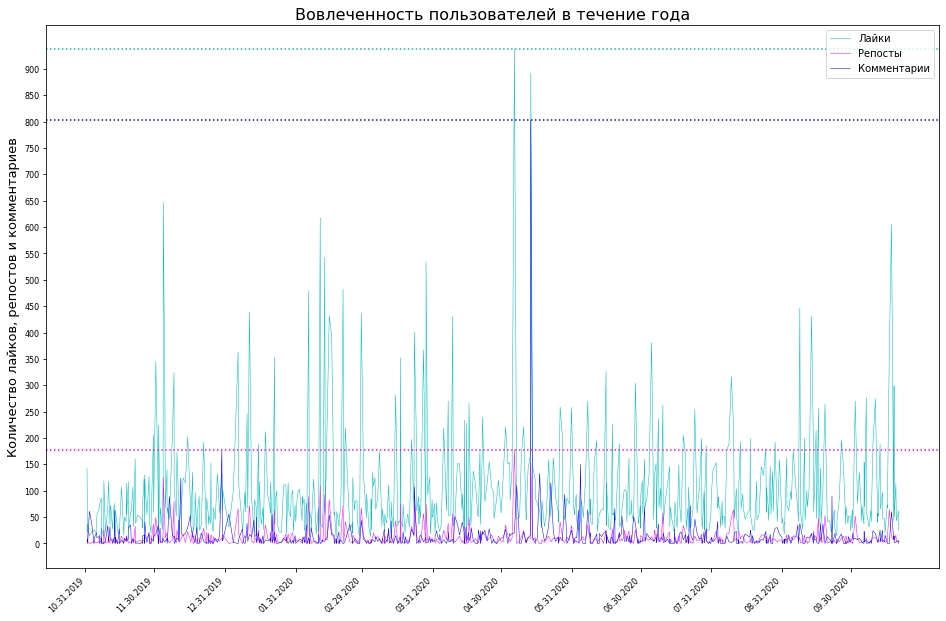

In [54]:
plt.figure(figsize=(16,10))
likes = plt.plot(df_active_year['date'], df_active_year['likes'], label='Лайки', color = 'c')
reposts = plt.plot(df_active_year['date'], df_active_year['reposts'], label='Репосты', color = 'magenta')
comments = plt.plot(df_active_year['date'], df_active_year['comments'], label='Комментарии', color = 'b')
plt.axhline(y = df_active_year['likes'].max(), ls=':', color = 'c')
plt.axhline(y = df_active_year['reposts'].max(), ls=':', color='magenta')
plt.axhline(y = df_active_year['comments'].max(), ls=':', color='b')
plt.setp([likes, reposts, comments], linewidth = 0.5, alpha = 1)
plt.xlabel(None)
plt.ylabel('Количество лайков, репостов и комментариев', fontsize = 13)
plt.xticks(dates, labels = [pd.to_datetime(str(date)).strftime("%m.%d.%Y") for date in dates], rotation = 45, ha = 'right', fontsize = 8)
plt.yticks(range(0, math.ceil(np.max(df_active_year['likes'])), 50), fontsize = 8)
plt.legend(loc = 'upper right')
plt.title('Вовлеченность пользователей в течение года', fontsize = 16)
plt.show()

In [55]:
pd.concat([df_active_year['likes'].describe().astype(int), df_active_year['reposts'].describe().astype(int), df_active_year['comments'].describe().astype(int), df_active_year['views'].describe().astype(int)], axis=1)

,likes,reposts,comments,views
count,646,646,646,646
mean,95,10,13,21567
std,101,17,36,10197
min,10,0,0,7994
25%,38,2,1,15568
50%,64,5,6,20104
75%,111,11,15,24755
max,937,178,802,122785


In [56]:
categories = ['November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']
df_active_year_by_months = df_active_year.groupby('month')[['likes', 'reposts', 'comments']]\
    .agg(['median', 'sum'])\
    .reindex(categories)
df_active_year_by_months

likes       reposts      comments      
          median   sum  median  sum   median   sum
month                                             
November    49.0  3768     4.0  420      6.0   680
December    68.0  6039     7.0  759      6.5   964
January     67.5  4628     7.0  601      6.0   553
February    62.0  6455     4.5  835      5.0   460
March       56.0  5507     4.0  684      4.0   532
April       63.0  4878     4.0  470      8.0   673
May         86.0  5920     7.0  683     12.0  1667
June        57.5  4796     5.0  441      7.5   846
July        68.5  5393     5.0  532      6.0   653
August      67.0  5062     6.0  507      5.0   467
September   62.0  5025     5.0  424      7.0   563
October     64.0  4336     5.0  329      5.0   342

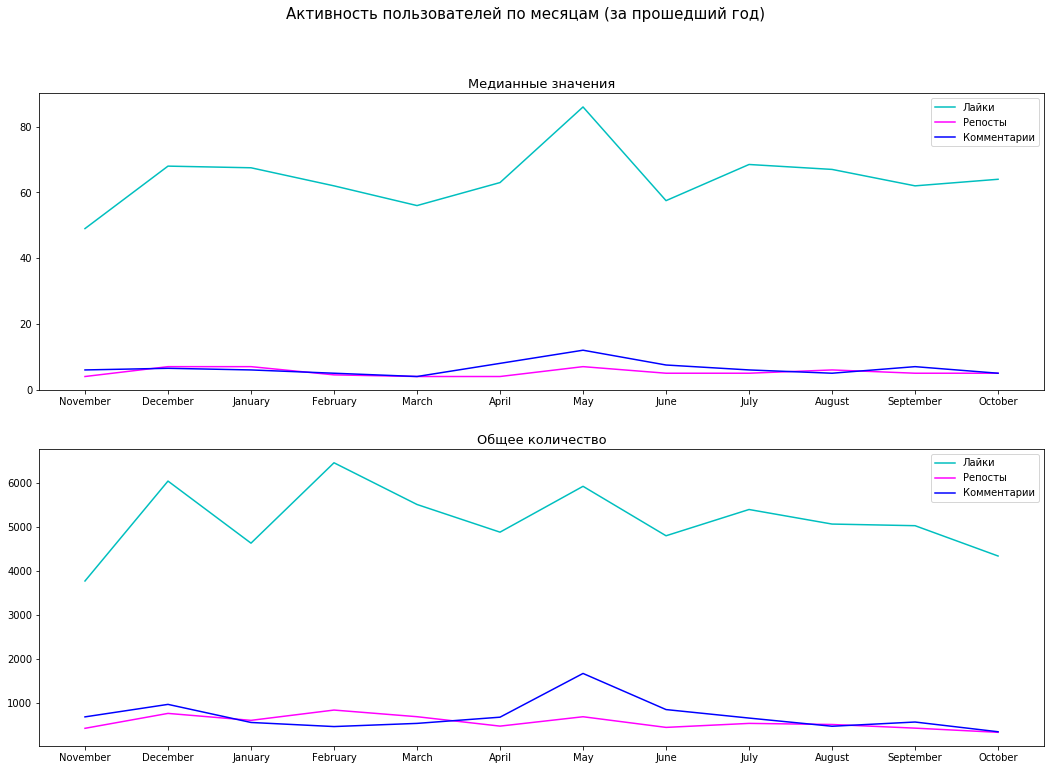

In [57]:
figure, ax = plt.subplots(2, 1, figsize = (18, 12))
figure.suptitle('Активность пользователей по месяцам (за прошедший год)', fontsize = 15)

ax[0].set_title('Медианные значения', fontsize = 13)
ax[0].plot(df_active_year_by_months.index, df_active_year_by_months['likes']['median'], label = 'Лайки', color = 'c')
ax[0].plot(df_active_year_by_months.index, df_active_year_by_months['reposts']['median'], label = 'Репосты', color = 'magenta')
ax[0].plot(df_active_year_by_months.index, df_active_year_by_months['comments']['median'], label = 'Комментарии', color = 'b')
ax[0].legend(loc = 'upper right')

ax[1].set_title('Общее количество', fontsize = 13)
ax[1].plot(df_active_year_by_months.index, df_active_year_by_months['likes']['sum'], label = 'Лайки', color = 'c')
ax[1].plot(df_active_year_by_months.index, df_active_year_by_months['reposts']['sum'], label = 'Репосты', color = 'magenta')
ax[1].plot(df_active_year_by_months.index, df_active_year_by_months['comments']['sum'], label = 'Комментарии', color = 'b')
ax[1].legend(loc = 'upper right')

plt.show()

Максимальная активность по всем медианным значениям зафиксирована в мае 2020 года: 86 у лайков, 7 у репостов, 12 у комментариев. При этом по общему количеству лайков (6455) и репостов (835) в месяц лидирует февраль. В декабре 2019 года суммарные значения также относительно высоки: 6039 лайков, 759 репостов, 964 комментариев. Это говорит о том, что в декабре и феврале было больше по количеству постов с меньшим количеством лайков, репостов и комментариев, чем в мае. То есть в мае активность пользователей была выше, не смотря на меньшее количество постов, что подтверждает вывод ниже (всего 39 постов при 60 и 56 в декабре и феврале соответственно).

Скорее всего всплески активности носят сезонный характер, связанный с маркетинговыми стимулирующими кампаниями в преддверии новогодних (декабрь), гендерных (февраль) праздников, и поддержанием спроса перед началом лета (май).

In [58]:
df_active_year_count_by_months = df_active_year.groupby('month')[['id']].agg(['count']).reindex(categories)
df_active_year_count_by_months

,id
,count
month,
November,65
December,60
January,52
February,56
March,59
April,50
May,39
June,58


In [59]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_active_year_by_weekdays = df_active_year.groupby(['weekday'])[['likes', 'reposts', 'comments']]\
    .agg(['median', 'sum'])\
    .reindex(cats)
df_active_year_by_weekdays

likes        reposts       comments      
          median    sum  median   sum   median   sum
weekday                                             
Monday        63  10323     5.0  1108        6  1554
Tuesday       52   8835     3.0   934        6  1084
Wednesday     58  10753     5.5  1316        5  1917
Thursday      56   8347     5.0   927        4  1254
Friday        65   7601     5.0   823        5   947
Saturday     115   7335     6.0   812        8   786
Sunday       130   8613    12.0   765       10   858

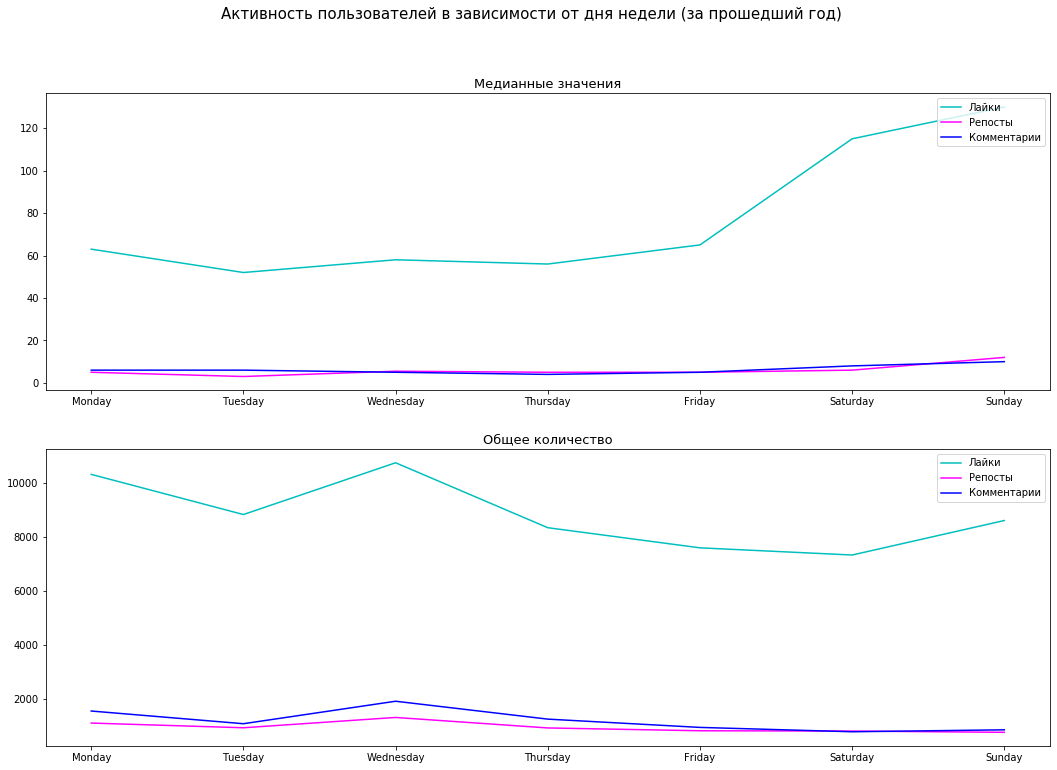

In [60]:
figure, ax = plt.subplots(2, 1, figsize = (18, 12))
figure.suptitle('Активность пользователей в зависимости от дня недели (за прошедший год)', fontsize = 15)

ax[0].set_title('Медианные значения', fontsize = 13)
ax[0].plot(df_active_year_by_weekdays.index, df_active_year_by_weekdays['likes']['median'], label = 'Лайки', color = 'c')
ax[0].plot(df_active_year_by_weekdays.index, df_active_year_by_weekdays['reposts']['median'], label = 'Репосты', color = 'magenta')
ax[0].plot(df_active_year_by_weekdays.index, df_active_year_by_weekdays['comments']['median'], label = 'Комментарии', color = 'b')
ax[0].legend(loc = 'upper right')

ax[1].set_title('Общее количество', fontsize = 13)
ax[1].plot(df_active_year_by_weekdays.index, df_active_year_by_weekdays['likes']['sum'], label = 'Лайки', color = 'c')
ax[1].plot(df_active_year_by_weekdays.index, df_active_year_by_weekdays['reposts']['sum'], label = 'Репосты', color = 'magenta')
ax[1].plot(df_active_year_by_weekdays.index, df_active_year_by_weekdays['comments']['sum'], label = 'Комментарии', color = 'b')
ax[1].legend(loc = 'upper right')

plt.show()

In [61]:
df_active_year_count_by_weekdays = df_active_year.groupby('weekday')[['id']].agg(['count']).reindex(cats)
count_by_weekdays_median = int(df_active_year_count_by_weekdays.median())

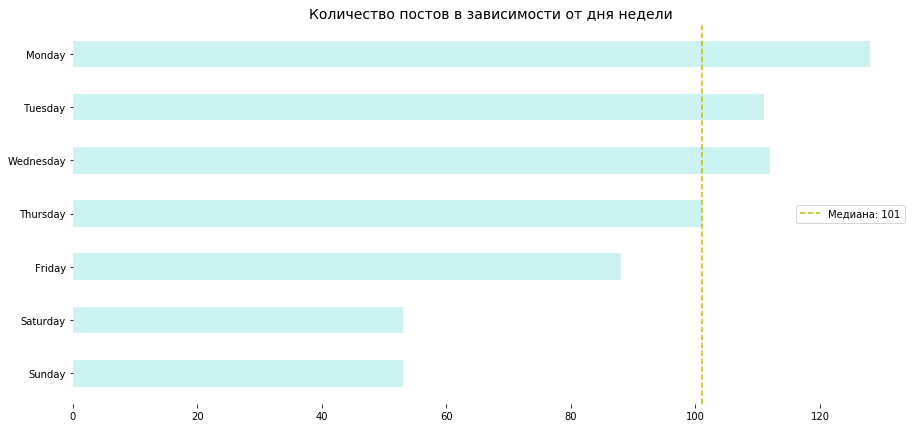

In [62]:
plt.figure(figsize=(15, 7))
plt.barh(df_active_year_count_by_weekdays.reindex(cats[::-1]).index, df_active_year_count_by_weekdays.reindex(cats[::-1])['id']['count'], height = 0.5, color = 'c', alpha = 0.2)
plt.axvline(x = count_by_weekdays_median, ls='--', color='y', label = 'Медиана: {}'.format(count_by_weekdays_median))
plt.title('Количество постов в зависимости от дня недели', size=14)
plt.legend(loc = 'center right')
plt.box(on = False)
plt.show()

На графиках выше мы видим обратно пропорциональную зависимость медианных значений активности к количеству размещаемых постов. Чем меньше размещаемых постов, тем больше активности на каждый из них. Количество размещаемых постов в выходные падает более чем вдвое (пн.: 128, сб. и вс.: 53), тем временем к воскресенью медианы активностей практически удваиваются. На общем количестве лайков, респостов и комментариев это сказывается не так заметно, но есть выраженные пики в понедельник и среду (сравнительная таблица со средними значениями представлена ниже).

In [63]:
df_active_year_by_weekdays.stack().loc[(cats, ['sum']) , :]\
    .agg(['max', 'mean'])\
    .rename(index = {'max' : 'Wednesday', 'mean' : 'All weekdays mean'})

,likes,reposts,comments
Wednesday,10753.000000,1316.0,1917.0
All weekdays mean,8829.571429,955.0,1200.0


In [64]:
df_active_year_by_hours = df_active_year.groupby(['time'])[['likes', 'reposts', 'comments']].agg(['median', 'sum'])
df_active_year_by_hours

likes        reposts       comments      
     median    sum  median   sum   median   sum
time                                           
08     73.0     73    10.0    10      5.0     5
09     76.0     76    11.0    11     12.0    12
10     51.0    951     4.0   113     15.0   212
11     80.0  10965     6.0  1231     10.0  1783
12     97.0  14154     7.0  1645     11.0  1815
13     81.0   6079     5.0   495      8.0   858
14     63.0   5153     4.0   309      7.0   658
15     52.5   3834     4.0   384      5.5   424
16     65.5   4097     3.5   475      4.0  1170
17     56.0   3873     4.0   466      4.0   380
18     50.5   5059     4.0   572      4.0   546
19     61.0   5429     7.0   740      4.0   382
20     47.0   2023     4.0   229      2.0   155
21     41.0     41     5.0     5      0.0     0

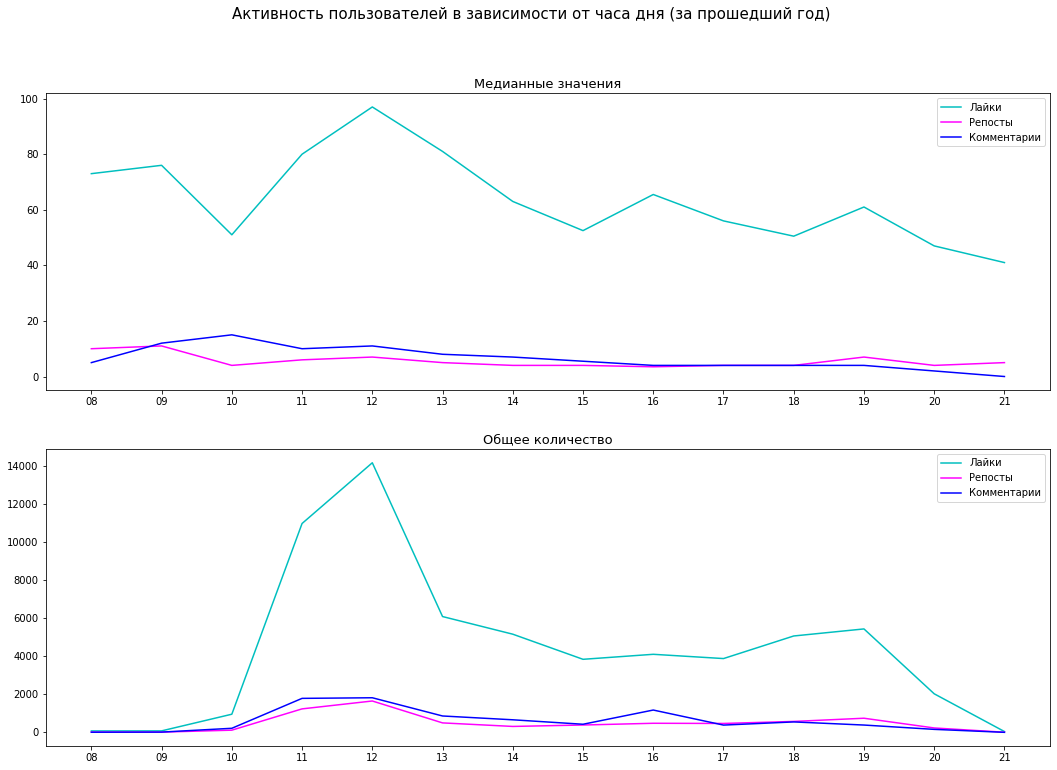

In [65]:
figure, ax = plt.subplots(2, 1, figsize = (18, 12))
figure.suptitle('Активность пользователей в зависимости от часа дня (за прошедший год)', fontsize = 15)

ax[0].set_title('Медианные значения', fontsize = 13)
ax[0].plot(df_active_year_by_hours.index, df_active_year_by_hours['likes']['median'], label = 'Лайки', color = 'c')
ax[0].plot(df_active_year_by_hours.index, df_active_year_by_hours['reposts']['median'], label = 'Репосты', color = 'magenta')
ax[0].plot(df_active_year_by_hours.index, df_active_year_by_hours['comments']['median'], label = 'Комментарии', color = 'b')
ax[0].legend(loc = 'upper right')

ax[1].set_title('Общее количество', fontsize = 13)
ax[1].plot(df_active_year_by_hours.index, df_active_year_by_hours['likes']['sum'], label = 'Лайки', color = 'c')
ax[1].plot(df_active_year_by_hours.index, df_active_year_by_hours['reposts']['sum'], label = 'Репосты', color = 'magenta')
ax[1].plot(df_active_year_by_hours.index, df_active_year_by_hours['comments']['sum'], label = 'Комментарии', color = 'b')
ax[1].legend(loc = 'upper right')

plt.show()

In [66]:
df_active_year_count_by_hours = df_active_year.groupby('time')[['id']].agg(['count'])
count_by_hours_median = int(df_active_year_count_by_hours.median())

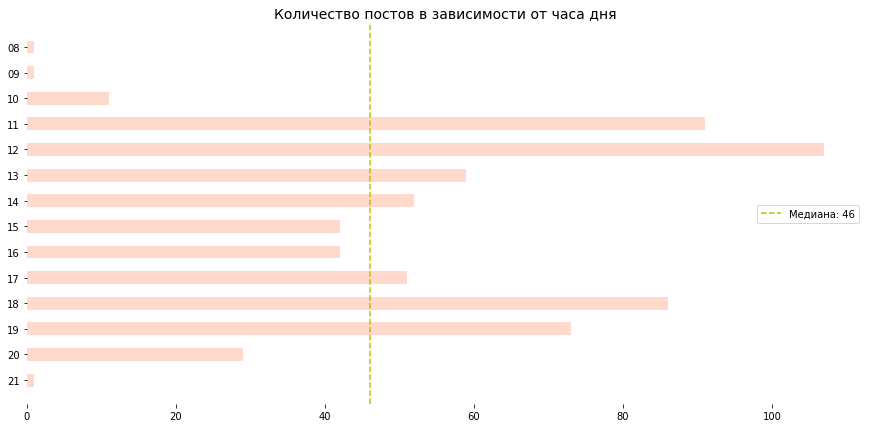

In [67]:
plt.figure(figsize=(15, 7))
plt.barh(df_active_year_count_by_hours.sort_index(ascending = False).index, df_active_year_count_by_hours.sort_index(ascending = False)['id']['count'], height = 0.5, color = 'orangered', alpha = 0.2)
plt.axvline(x = count_by_hours_median, ls='--', color='y', label = 'Медиана: {}'.format(count_by_hours_median))
plt.title('Количество постов в зависимости от часа дня', size=14)
plt.legend(loc = 'center right')
plt.box(on = False)
plt.show()

Здесь мы видим корреляцию графиков активности и количества выложенных постов в зависимости от часа дня.

За отчетный период посты выкладывались с 8 утра до 22 часов вечера. Отчетливо видны пики с 11 до 13 (91-107 постов) и с 18 до 19 (86 постов) часов.

Наиболее высока активность в первой половине дня с 11 до 14 часов. Менее выраженный пик активности наблюдается в районе 18-20 часов вечера. При этом еще есть участок повышенной активности с 16 до 17 часов, который не учитывается при размещении постов.

Также замечены поведенческие особенности пользователей (из-за малого количества данные требуют дополнительной проверки): в утренние часы с 8 до 10 утра часто на каждый пост ставят лайки и делают репосты, а с 9 до 11 активность смещается в пользу комментариев.

В целом можно рекомендовать увеличить количество размещений постов в выходные дни. Сдвинуть часть размещаемых постов после 17 часов на час ранее (с 16 до 17). Желательно поэкспериментировать с размещением постов с 21 до 24 часов, учитывая особенности "работы до поздна" креативного класса, на который ориентирована платформа.

In [100]:
df_programming = df_active_year[df_active_year['text'].str.contains('#Skillbox_Программирование') == True]
df_programming

,id,date,month_number,month,weekday,time,likes,reposts,comments,views,text
4,116462,2020-10-19 19:00:27,10,October,Monday,19,50,5,2,16166,"Разбираемся, с чего начинать в программировани..."
39,100940,2020-09-30 18:00:09,09,September,Wednesday,18,24,3,4,17662,Комментировать свой код — обязательный навык п...
51,99820,2020-09-23 19:54:48,09,September,Wednesday,19,27,3,19,19802,Удивительное дело: компьютерный вирус в 1994 г...
61,98539,2020-09-17 18:53:25,09,September,Thursday,18,37,3,4,20812,"""Смертельная инъекция"" — звучит жутко, правда?..."
78,94587,2020-09-08 18:42:14,09,September,Tuesday,18,60,1,32,21450,Максим не смог стать программистом в университ...
80,94108,2020-09-07 21:03:31,09,September,Monday,21,41,5,0,20711,"Мобильный разработчик — это тот, который быстр..."
87,92268,2020-09-02 20:19:39,09,September,Wednesday,20,72,9,0,19213,"Представьте, что вы — директор компании и наня..."
97,91396,2020-08-27 19:40:46,08,August,Thursday,19,61,7,16,21385,"""Подскажите, как пройти в библиотеку?"" — что-т..."
210,79017,2020-06-29 20:26:24,06,June,Monday,20,38,1,0,19944,— Какие три мировых тренда будут актуальны в м...
218,77430,2020-06-25 19:00:34,06,June,Thursday,19,54,2,15,20204,У нас не совсем обычный обзор необычной игры. ...


За отчетный период размещено 13 постов с тегом #Skillbox_Программирование, 6 в сентябре, 5 в июне, по одному в августе и октябре.

In [149]:
main_text = []
regular_expr = r'\w+'
reg_expr_compiled = re.compile(regular_expr)
for raw_text in df_programming.text.values:
    raw_text_lower = raw_text.lower()
    text_by_words = reg_expr_compiled.findall(raw_text_lower)
    main_text += text_by_words

In [144]:
morph = pymorphy2.MorphAnalyzer()
normalized_text = []
for word in main_text:
    parsed_token = morph.parse(word)
    normal_form = parsed_token[0].normal_form
    normalized_text.append(normal_form)

In [145]:
df_words = pd.DataFrame(normalized_text, columns=['words'])
df_words_count = df_words.assign(count = 1).groupby('words').sum().sort_values(by = 'count', ascending = False)

In [146]:
pos = {'INTJ', 'PRCL', 'CONJ', 'PREP', 'NPRO', 'UNKN'}
words_list = df_words_count.index.tolist()
words_list_trimmed = [word for word in words_list if morph.parse(word)[0].tag.POS in pos] + ['skillbox_программирование', 'статья_skillbox', 'vk', 'cc', 'https', 'свой', 'самый', 'тот', 'весь', 'который', 'этот', 'сам', 'наш', 'можно', 'мочь', 'вскоре', 'где', 'теперь']
df_words_count_trimmed = df_words_count.loc[~df_words_count.index.isin(words_list_trimmed)]

In [147]:
df_words_count_trimmed[df_words_count_trimmed['count'] > 2]

,count
words,
игра,9
курс,7
мобильный,6
почитать,4
программист,4
стать,4
человек,3
сеть,3
какой,3


В текстах постов про программирование чаще всего используется слово Игра. Три и более раз встречаются обычные для темы слова, такие как Программист, Разработчик, Программирование, Язык. Слова Мобильный (речь идет о мобильных приложениях) и Игра самые популярные, отражающие тенденции в современной разработке. Также часто видны призывы Почитать, Стать, Сделать, Работать, которые в сочетании с популярностью слова Курс говорят о маркетинговой составляющей текстов, стимулирующих к взаимодействию и приобретению.